# MNIST encoder-decoder
A encoder-decoder system that encode mnist(28x28)image to 16-dimension vector and decode it.


# Library Import

In [91]:
import numpy as np
import pandas as pd
import gc
import os
import cv2
import matplotlib.pyplot as plt
import random
import shutil

try:
    import keras
    from keras.models import Sequential
    from keras.models import Model
    from keras.layers import Dense, Dropout, Flatten, Input
    from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Conv2DTranspose
    from keras.layers.core import Reshape
    from keras.preprocessing.image import ImageDataGenerator
    from keras.layers import BatchNormalization
    from keras.utils import to_categorical
    from keras.utils import plot_model
except:
    print('Cannot import keras')
print('Library imported')

Library imported


# Dataset Load

In [2]:
def load_dataset(name):
    csv = pd.read_csv(f'../input/mnist-in-csv/mnist_{name}.csv')
    y = np.reshape(to_categorical(csv[csv.columns[0]].to_numpy(np.float32)),(-1,10))
    x = csv[csv.columns[1:]].to_numpy(np.float32)
    x = list(np.reshape(x,(-1,28,28)))
    for i in range(len(x)):
        x[i] = cv2.resize(x[i],(32,32))
    x = np.reshape(x,(-1,32,32,1))
        
    return x,y

x_test,y_test = load_dataset('test')
x_train,y_train = load_dataset('train')

# Visualize Dataset

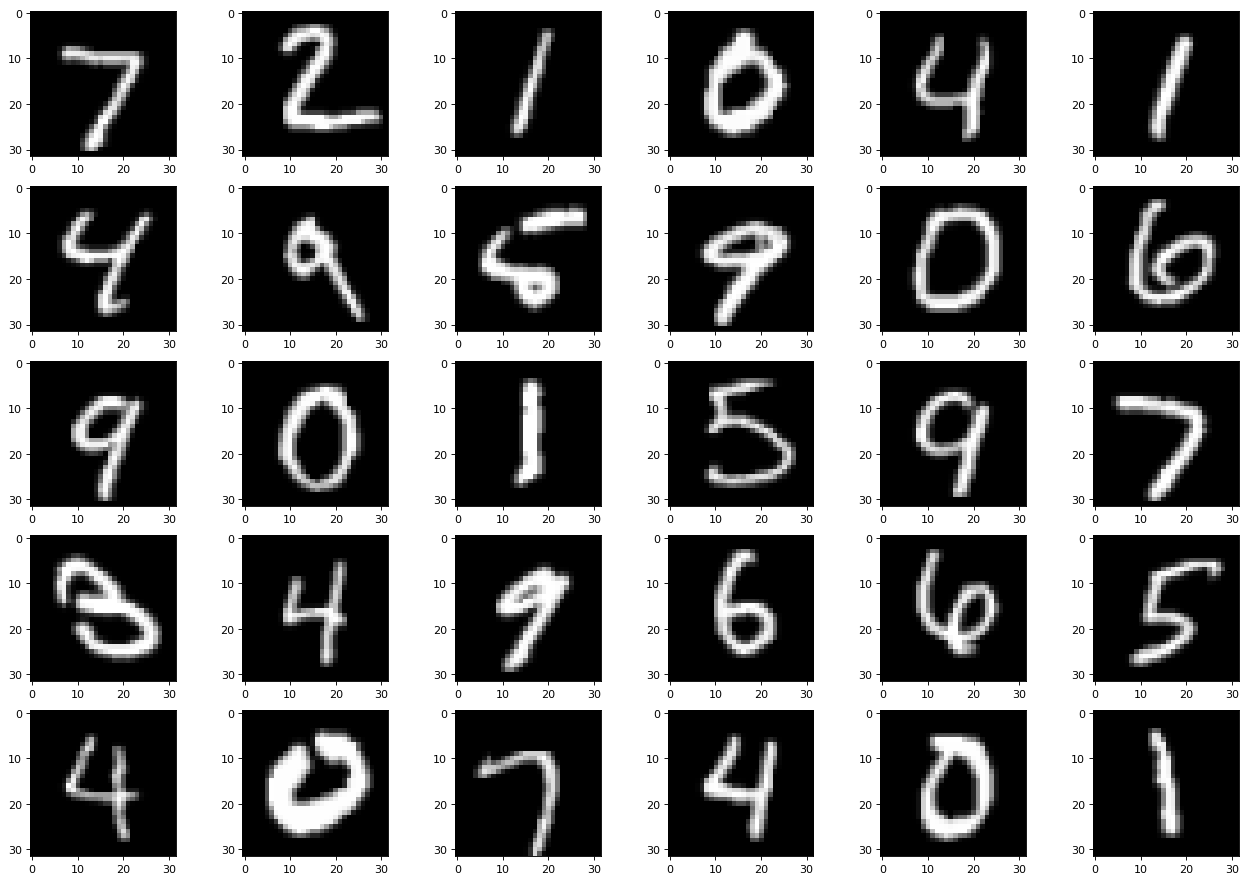

In [67]:
# Visualize
def visualize(data,W=6,H=5):
    gc.collect()
    FIG_WIDTH = 20
    FIG_HEIGHT = int(FIG_WIDTH*200/237*H/W)
    fig=plt.figure(figsize=(FIG_WIDTH,FIG_HEIGHT), dpi= 80, facecolor='w', edgecolor='k')
    subplots = fig.subplots(H,W)
    for i in range(H):
        for j in range(W):
            tmp = data[i*W+j]
            subplots[i][j].imshow(tmp, cmap=plt.get_cmap('gray'))
visualize(np.reshape(x_test,(-1,32,32)))

# Image Augmentation

In [4]:
try:
    validation_rate = 0.1
    
#     Apply image distortion
    datagen = ImageDataGenerator(
#         Distribution normalize
        samplewise_center=True,
        samplewise_std_normalization=True,
        
#         Geometric transform
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=10,
        zoom_range=0.05)
    datagen.fit(x_train)
    
    print('Train shape :',x_train.shape,y_train.shape)
    print('Test shape :',x_test.shape,y_test.shape)
except Exception as e:
    print(e)
finally:
    gc.collect()
# visualize(x_train)

Train shape : (60000, 32, 32, 1) (60000, 10)
Test shape : (10000, 32, 32, 1) (10000, 10)


# Layer Preset

In [25]:
dropout = 0.4

def downsample(layer,filters):
    layer = Conv2D(filters,kernel_size=3,activation='relu', padding='same', strides=(2,2))(layer)
#     layer = BatchNormalization()(layer)
    return layer

def upsample(layer,filters):
    layer = Conv2DTranspose(filters,kernel_size=3,activation='relu', padding='same', strides=(2,2))(layer)
    return layer

def dense(layer,nodes):
    layer = Dense(nodes, activation='relu')(layer)
    layer = BatchNormalization()(layer)
    return layer

def get_down(layer):
    layer = downsample(layer,32)
    layer = downsample(layer,64)
    layer = downsample(layer,64)
    return layer

def get_up(layer):
    layer = upsample(layer,64)
    layer = upsample(layer,64)
    layer = upsample(layer,32)
    return layer


# Model Construct

In [ ]:
model_x = Input(shape=(32,32,1))

model_in = Conv2D(1,kernel_size=1,padding='same')(model_x)
model_in = get_down(model_in)
model_in = Flatten()(model_in)
model_in = dense(model_in,256)
model_in = dense(model_in,64)
model_in = Dense(16,activation='sigmoid')(model_in)

model_en = Input(shape=(16,))
model_out = dense(model_en,64)
model_out = dense(model_out,256)
model_out = dense(model_out,4*4*64)
model_out = Reshape((4,4,64))(model_out)
model_out = get_up(model_out)
model_out = Conv2D(1,kernel_size=1,activation='relu', padding='same')(model_out)

encoder = Model(model_x, model_in)
encoder.compile(optimizer="adam", loss='mean_squared_error')

decoder = Model(model_en,model_out)
decoder.compile(optimizer="adam", loss='mean_squared_error')

trainer = Model(model_x,decoder(encoder(model_x)))
trainer.compile(optimizer="adam", loss='mean_squared_error')


Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
model_46 (Model)             (None, 16)                336914    
_________________________________________________________________
model_47 (Model)             (None, 32, 32, 1)         378625    
Total params: 715,539
Trainable params: 712,211
Non-trainable params: 3,328
_________________________________________________________________


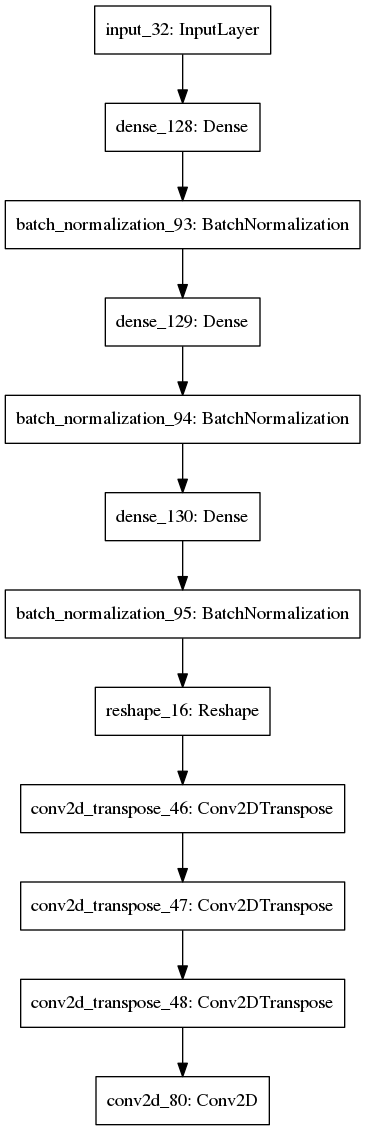

In [93]:
trainer.summary()
plot_model(encoder, to_file='model_encoder.png', show_shapes=True, show_layer_names=False)
plot_model(decoder, to_file='model_decoder.png', show_shapes=True, show_layer_names=False)

# Model Train

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 7s 121us/step - loss: 437.3443 - val_loss: 537.3219
Epoch 2/6
60000/60000 [==============================] - 9s 142us/step - loss: 422.7515 - val_loss: 412.6408
Epoch 3/6
60000/60000 [==============================] - 7s 124us/step - loss: 415.9812 - val_loss: 426.1010
Epoch 4/6
60000/60000 [==============================] - 7s 119us/step - loss: 402.1158 - val_loss: 371.8077
Epoch 5/6
60000/60000 [==============================] - 7s 121us/step - loss: 390.5680 - val_loss: 372.8656
Epoch 6/6
60000/60000 [==============================] - 7s 122us/step - loss: 381.9230 - val_loss: 353.8462


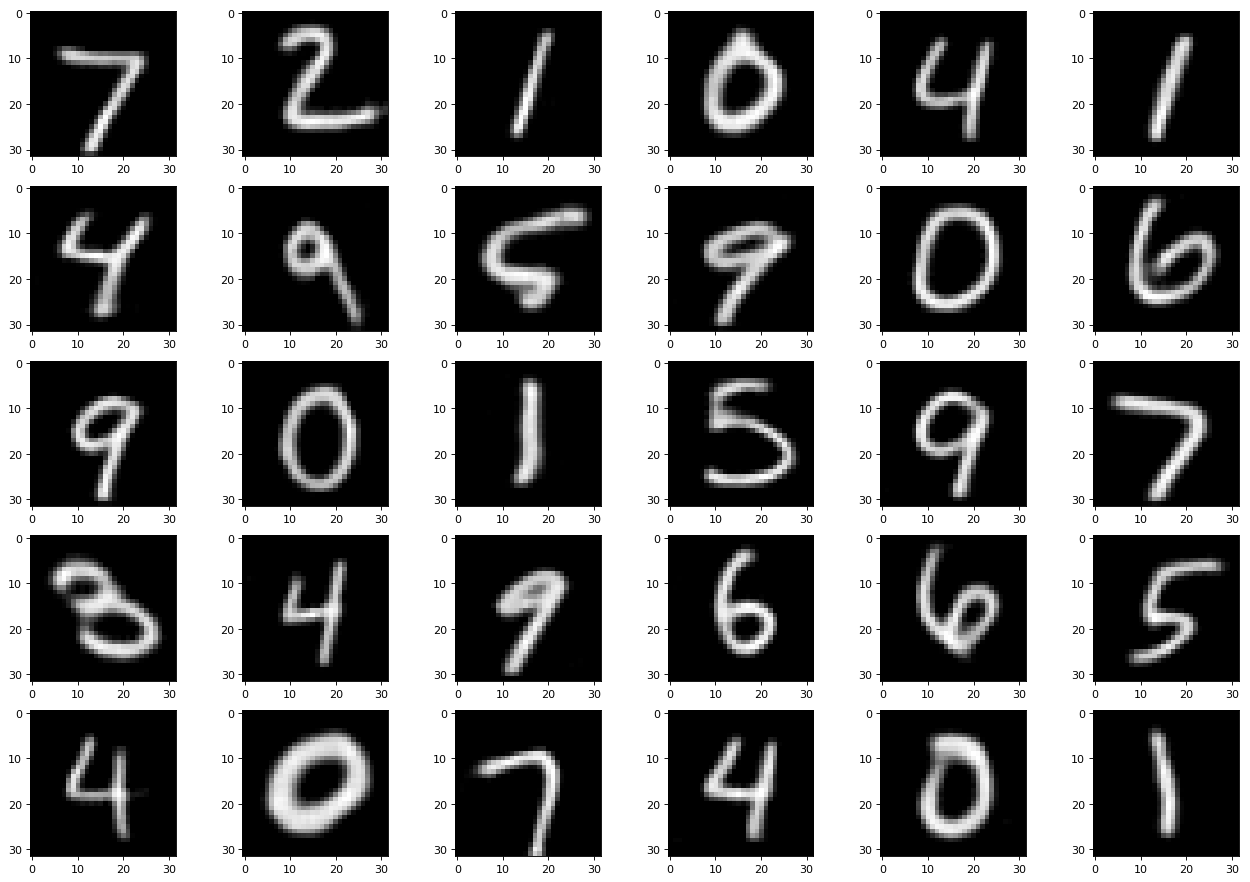

In [70]:
try:
    trainer.fit(
        x_train,x_train,
        batch_size = 128,
        epochs=6, 
        verbose=1,
        validation_data=(x_test, x_test),
        shuffle=True)
    
except KeyboardInterrupt:
    pass
except Exception as e:
    print(e)

result = trainer.predict(x_test)
result = np.reshape(result, (-1,32,32))
visualize(result)

# Smooth Transform Test

[[0.40254045 0.65370446 0.23500267 ... 0.5136184  0.59278035 0.5504826 ]
 [0.66930485 0.2269614  0.73307604 ... 0.55979997 0.78716516 0.31519476]
 [0.5010898  0.5892555  0.48991776 ... 0.48062894 0.7023456  0.67274255]
 ...
 [0.5620477  0.6455807  0.67030156 ... 0.33069855 0.43952063 0.65465844]
 [0.32629266 0.33540076 0.39660874 ... 0.5614698  0.4396263  0.5564968 ]
 [0.5224823  0.45856026 0.7066495  ... 0.61250263 0.4682918  0.49243623]]


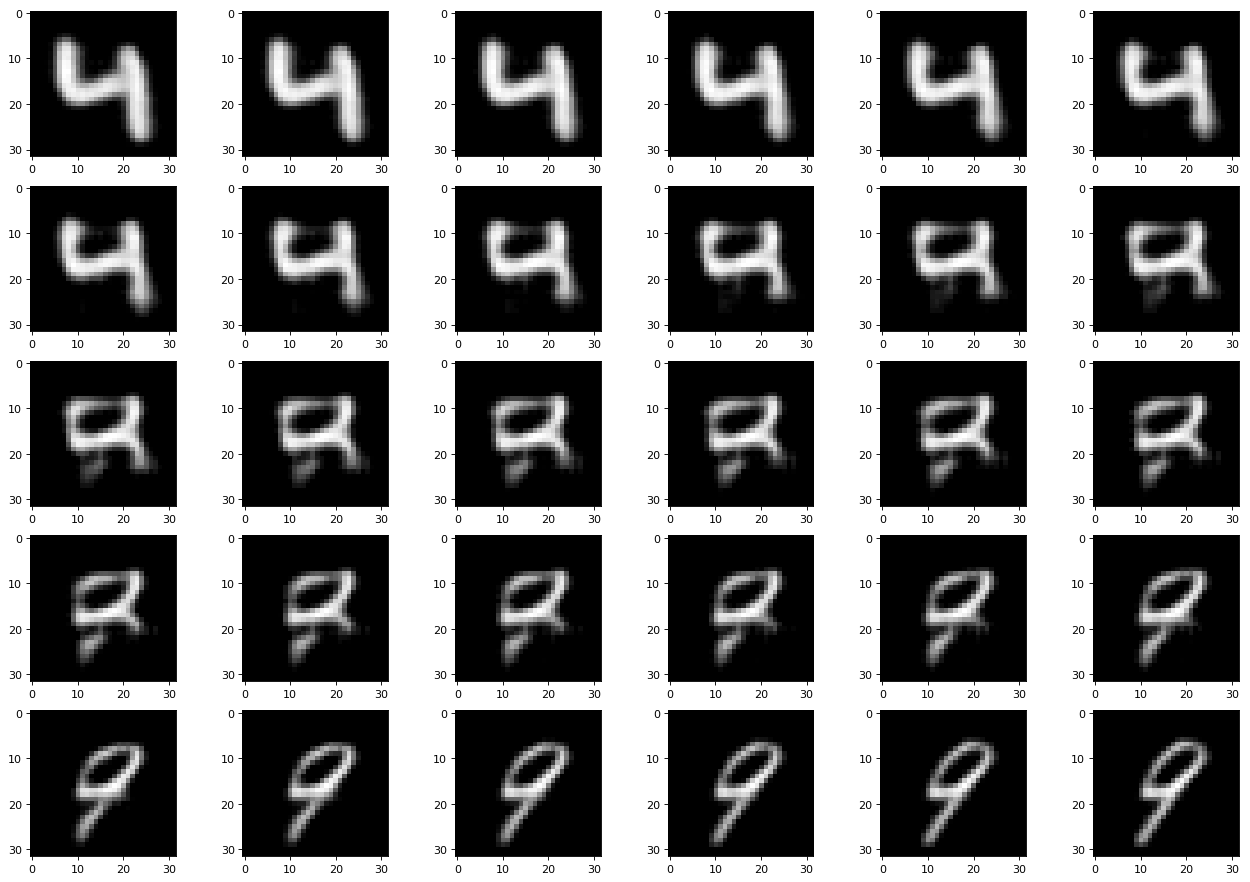

In [78]:
r = encoder.predict(x_test)
print(r)
imA = r[random.randint(0,1000)]
imB = r[random.randint(0,1000)]

ip = []
for i in range(30):
    ip.append((imA*(29-i)+imB*i)/30)
ip = np.array(ip)    
ipr = decoder.predict(ip)
ipr = np.reshape(ipr,(-1,32,32))
visualize(ipr)

# Random Noise to Number

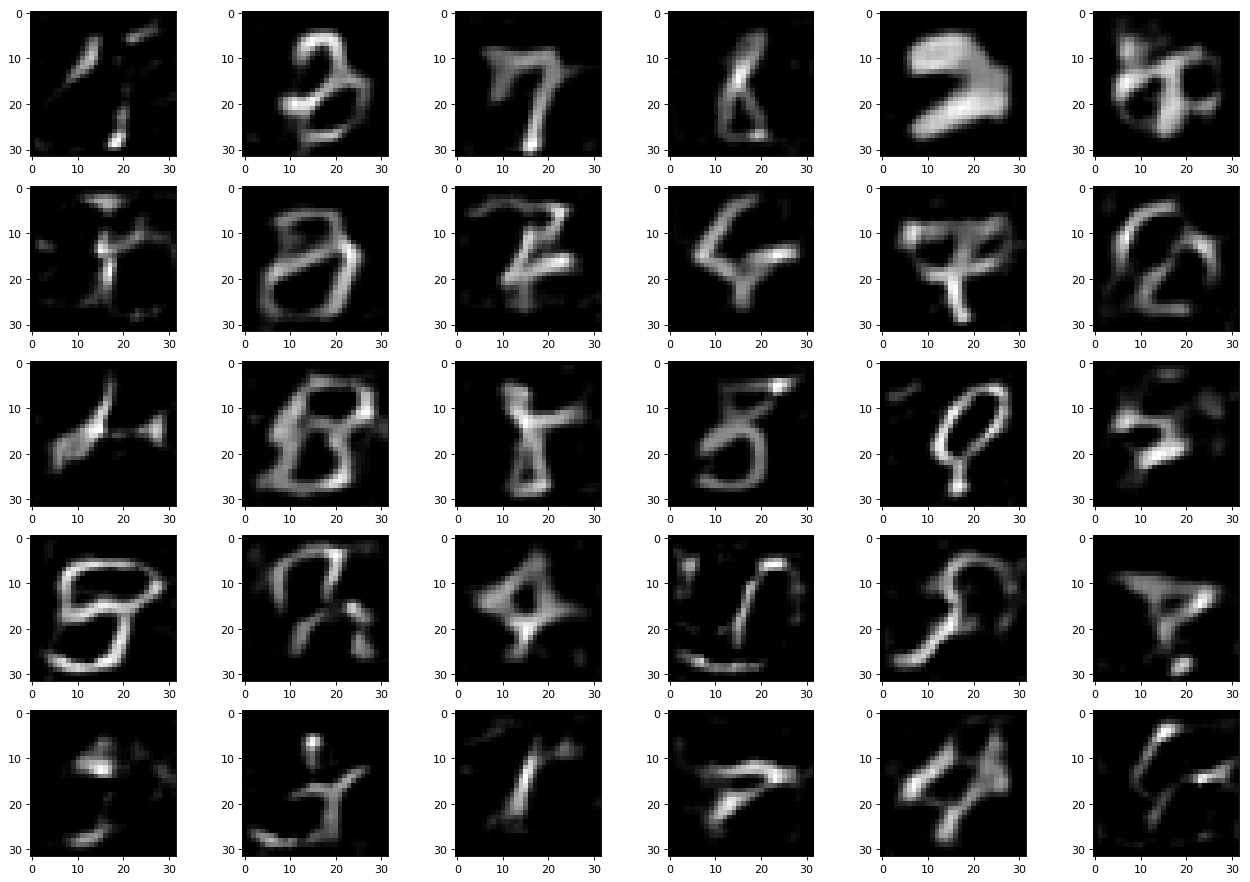

In [85]:
randencoded = np.random.rand(32,16)
decoded = decoder.predict(randencoded)
ipr = np.reshape(decoded,(-1,32,32))
visualize(ipr)

# One-Hot

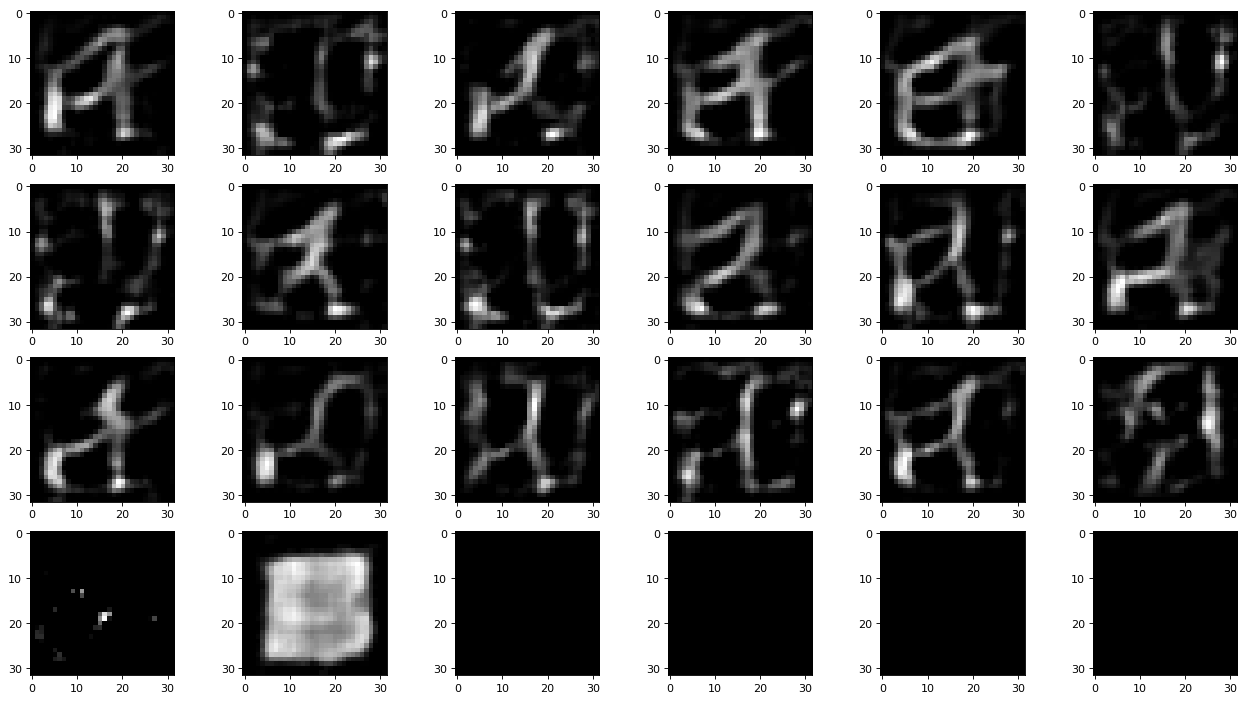

In [90]:
empty = np.zeros([1,32,32,1])
empty = encoder.predict(empty)
full  = np.ones([1,32,32,1])*255
full  = encoder.predict(full)

randencoded = np.zeros((32,16))
for i in range(16):
    randencoded[i,i] = 1
randencoded[16] = np.zeros(16)
randencoded[17] = np.ones(16)
randencoded[18] = empty
randencoded[19] = full

decoded = decoder.predict(randencoded)
decoded[20:]=0

ipr = np.reshape(decoded,(-1,32,32))
visualize(ipr,H=4)